# iCAT import
---

#### Overview
The purpose of this notebook is to guide and facilitate in the creation of `render-ws` stacks. These stacks are made up of metadata regarding a collection of image tiles such as the geometric bounds, number of tiles and sections, resolution, etc. Each image tile in a stack has its own respective metadata as well, called a [tile specification](https://render-python.readthedocs.io/en/latest/guide/index.html#making-a-new-stack). Using [`pandas`](https://pandas.pydata.org/) and the [`icatapi`](https://github.com/lanery/iCAT-workflow/tree/master/icatapi), this notebook creates these tile specifications from image metadata, gathers them into stacks, and uploads the stacks to a local `render-ws` server.


#### Naming conventions
Within the context of the iCAT workflow, a collection of images from a single data source (e.g. individual fluorescence channel) is referred to as a "tileset". The collection of multiple data sources across an individual section is referred to as a "layer", while a "stack" is the collection of the same individual data source across multiple sections. A "project" is then a collection of multiple stacks.

-            | 1 section | > 1 section
------------ | --------- | -----------
\> 1 channel | layer     | project (or stacks)
1 channel    | tileset   | stack


#### Packages

In [1]:
from pathlib import Path
import re

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import TiffFile

import renderapi
import icatapi

/home/skaracoban/miniconda3/envs/icat/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_3353766/1190656210.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Settings

In [2]:
# Indirectly enable autocomplete
%config Completer.use_jedi = False

# pandas display options
pd.set_option('display.max_colwidth', 20)

## 1) Set up environment
---

#### Connect to `render-ws`

In [3]:
# `render-ws` parameters
owner = 'skaracoban'
project = '20240530_SK001_2'

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'http://localhost',
    'port': 8081,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G',
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://localhost',
 'port': 8081,
 'owner': 'skaracoban',
 'project': '20240530_SK001_2',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

#### Set project directory

In [4]:
# Directory where raw data is stored
dir_project = Path("/long_term_storage/skaracoban/data/20240530_SK001/T1")

# Stack directory
print(dir_project, ':\n'+'.'*len(dir_project.as_posix()))
!ls -l $dir_project | head -n 6

/long_term_storage/skaracoban/data/20240530_SK001/T1 :
....................................................
total 0
drwxrwxr-x 5 skaracoban skaracoban 71 Jun  7 11:21 _mipmaps
drwxrwxr-x 4 skaracoban skaracoban 50 Jun  3 16:11 S001
drwxrwxr-x 4 skaracoban skaracoban 50 Jun  5 10:02 S002
drwxrwxr-x 4 skaracoban skaracoban 50 Jun  3 16:11 S003


#### Link sections to z values

In [5]:
# Create section mapping
dir_sections = [dir_ for dir_ in dir_project.glob('[!_]*') if dir_.is_dir()]
d_sections = {dir_section.name: i for i, dir_section in enumerate(dir_sections)}
d_sections

{'S002': 0, 'S003': 1, 'S001': 2}

## 2) Create mipmaps
---

#### Raw data organization scheme
```
┌ {project}
└───┬ {sectionId}
    ├───┬ CLEM-grid
    │   └──── tile-{col}x{row}.tif
    └───┬ EM-grid
        ├──── tile-00002x00002.tif
        ├──── tile-00002x00003.tif
        ├──── ...
        └──── tile-{col}x{row}.tif
```

#### Mipmap output scheme
```
┌ {project}
└───┬ _mipmaps
    └───┬ {stack}
        └───┬ {sectionId}
            ├───┬ 00002x00002
            │   ├──── mm_00.tif
            │   ├──── mm_01.tif
            │   ├──── ...
            │   └──── mm_{zoom}.tif
            ├──── 00002x00003
            ├──── ...
            └──── {col}x{row}
```

In [6]:
from bs4 import BeautifulSoup as Soup
from icatapi.importo import create_mipmaps

In [17]:
# Assume subdirectories of project directory are different stacks (durr)
from curses import meta

def _fnc(fp):
    # Read tiff
    tif = TiffFile(fp)
    # Extract metadata into dict as {'channel 1': metadata,
    #                                'channel 2': metadata, ...}
    metadata = tif.pages[0].description
    metadata = "\n".join(metadata.split("\n")[7:])
    # Infer col, row
    col, row = [int(i) for i in re.findall(r'\d+', fp.stem)][-2:]

    # Infer stack
    channel = tif.pages[0].tags['PageName'].value
    if channel == 'Secondary electrons':
        stack = 'EM_himag'
    else:
        raise ValueError(f"Channel {channel} is not electron microscopy data.")

    # Create mipmaps
    image = tif.asarray()
    dir_out = dir_project / '_mipmaps' / stack / sectionId / f"{col:05d}x{row:05d}"
    dir_out.mkdir(parents=True, exist_ok=True)
    create_mipmaps(image=image, dir_out=dir_out, invert=True,
                    metadata=metadata)

dir_stacks = [dir_ for dir_ in dir_project.iterdir() if dir_.is_dir()]

# Loop through section directories
for z, dir_section in tqdm(enumerate(dir_sections),
                           total=len(dir_sections)):

    # Set sectionId
    sectionId = dir_section.name

    # CLEM-grid
    # ---------
    for fp in tqdm(list(dir_section.glob('CLEM-grid/*-*x*.tif')),
                   leave=False):
        # Read tiff
        tif = TiffFile(fp)
        # Extract metadata into dict as {'channel 1': metadata,
        #                                'channel 2': metadata, ...}
        metadata = tif.pages[0].description
        metadata = "\n".join(metadata.split("\n")[7:])
        
        d_metadata = {md.attrs['name']: md for md in Soup(metadata, 'lxml').find_all('image')}
        # Infer col, row
        col, row = [int(i) for i in re.findall(r'\d+', fp.stem)][-2:]

        # Loop through tiff pages
        for page in tif.pages:

            # Infer stack
            channel = page.tags['PageName'].value
            if channel == 'Secondary electrons':
                stack = 'EM_lomag'
                invert = True
            else:  # set stack name based on the excitation wavelength for FM channels
                wavelength = d_metadata[channel].channel.attrs['excitationwavelength']
                stack = f"exc_{wavelength}nm"
                invert = False

            # Create mipmaps
            image = page.asarray()
            dir_out = dir_project / '_mipmaps' / stack / sectionId / f"{col:05d}x{row:05d}"
            dir_out.mkdir(parents=True, exist_ok=True)
            _metadata = d_metadata[channel].encode(encoding='utf-8')
            create_mipmaps(image=image, dir_out=dir_out, invert=invert,
                           metadata=_metadata)

    # EM-grid
    # -------
    for fp in tqdm(list(dir_section.glob('EM-grid/*-*x*.tif')),
                   leave=False):
        # Read tiff
        tif = TiffFile(fp)
        # Extract metadata into dict as {'channel 1': metadata,
        #                                'channel 2': metadata, ...}
        metadata = tif.pages[0].description
        metadata = "\n".join(metadata.split("\n")[7:])
        # Infer col, row
        col, row = [int(i) for i in re.findall(r'\d+', fp.stem)][-2:]

        # Infer stack
        channel = tif.pages[0].tags['PageName'].value
        if channel == 'Secondary electrons':
            stack = 'EM_himag'
        else:
            raise ValueError(f"Channel {channel} is not electron microscopy data.")

        # Create mipmaps
        image = tif.asarray()
        dir_out = dir_project / '_mipmaps' / stack / sectionId / f"{col:05d}x{row:05d}"
        dir_out.mkdir(parents=True, exist_ok=True)
        create_mipmaps(image=image, dir_out=dir_out, invert=True,
                       metadata=metadata)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_3289734/4174216039.py:25: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  d_metadata = {md.attrs['name']: md for md in Soup(metadata, 'lxml').find_all('image')}


  0%|          | 0/144 [00:00<?, ?it/s]

<tifffile.TiffFile 'tile-00004x00001.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00000.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00004x00003.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00001.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00004x00002.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00002.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00004x00004.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00003.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

<tifffile.TiffFile 'tile-00003x00010.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00003x00011.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00004x00000.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00000.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00004x00001.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00001.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00004x00002.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00002.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

<tifffile.TiffFile 'tile-00004x00001.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00000.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00004x00003.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00001.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00004x00002.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00002.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00004x00004.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00003.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')


## 3) Create tile specifications
---

#### [`TileSpec`](https://github.com/fcollman/render-python/blob/master/renderapi/tilespec.py#L17) parameters

| Field        | Type           | Default | Description
| -----        | ----           | ------- | -----------
| tileId       | str            | None    | Unique string specifying a tile's identity
| z            | float          | None    | z values this tile exists within
| width        | int            | None    | Width in pixels of the raw tile
| height       | int            | None    | Height in pixels of the raw tile
| imagePyramid | `ImagePyramid` | None    | `ImagePyramid` for this tile
| minint       | int            | 0       | Pixel intensity value to display as black
| maxint       | int            | 65535   | Pixel intensity value to display as white
| layout       | `Layout`       | None    | a `Layout` object for this tile
| tforms       | list           | [ ]     | Transform objects


#### [`Layout`](https://github.com/fcollman/render-python/blob/master/renderapi/layout.py#L1) parameters

| Field     | Type  | Default | Description                                  |
| -----     | ----  | ------- | -----------                                  |
| sectionId | str   | None    | sectionId this tile was taken from           |
| scopeId   | str   | None    | What microscope this came from               |
| cameraId  | str   | None    | Camera this was taken with                   |
| imageRow  | int   | None    | Row from a row,col layout this was taken     |
| imageCol  | int   | None    | Column from a row,col layout this was taken  |
| stageX    | float | None    | X stage coordinates for where this was taken |
| stageY    | float | None    | Y stage coordinates for where this was taken |
| rotation  | float | None    | Angle of camera when this was taken          |
| pixelsize | float | None    | Effective size of pixels                     |


#### Building tile specifications
Will build tile specifications from base level mipmaps (which contain the metadata).

In [18]:
# Collect tile specifications
tile_dicts = []

# Subdirectories of _mipmpap directory are the different stacks
dir_stacks = [dir_ for dir_ in (dir_project/'_mipmaps').iterdir() if dir_.is_dir()]
# Loop through stacks
for dir_stack in tqdm(dir_stacks):

    # Set stack name
    stack = dir_stack.name

    # Loop through sections
    dir_sections = [dir_ for dir_ in dir_stack.iterdir() if dir_.is_dir()]
    for dir_section in tqdm(dir_sections):

        # Set sectionId and z value
        sectionId = dir_section.name
        z = d_sections[sectionId]

        # Loop through mipmap directories within each section
        for dir_mipmap in dir_section.glob('*x*'):

            # Set base-level tiff
            fp = dir_mipmap / '0.tif'

            # Create tile dict
            d_tile = {}
            d_tile['stack'] = stack
            d_tile['z'] = z
            d_tile['sectionId'] = sectionId
            d_tile = icatapi.importo.create_tile_dict(fp, d_tile=d_tile, host="")
            # Add to collection
            tile_dicts.append(d_tile)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/home/skaracoban/render_code/iCAT-workflow/icatapi/importo.py:38: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = Soup(metadata, 'lxml')


#### Create stack DataFrames

In [19]:
# Create DataFrame from list of tile specifications
df_stacks = pd.DataFrame(tile_dicts)
# Infer stacks and z values
stacks = df_stacks['stack'].unique().tolist()
z_values = df_stacks['z'].unique().tolist()


# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(1))

/tmp/ipykernel_3353766/1246832016.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


stack  z sectionId  imageRow  imageCol       stageX  \
stack                                                                    
EM_himag  251   EM_himag  1      S003         8         8 -7260.736071   
EM_lomag  5     EM_lomag  2      S001         0         0 -7157.427625   
exc_470nm 0    exc_470nm  0      S002         0         0 -6945.331268   

                    stageY   pixelsize             acqTime  \
stack                                                        
EM_himag  251 -1381.815509    4.882812 2024-05-30 10:53:17   
EM_lomag  5   -1742.464102   36.621094 2024-05-30 09:32:57   
exc_470nm 0   -1405.688870  109.274672 2024-05-31 08:01:46   

                      imagePyramid               tileId  width  height  \
stack                                                                    
EM_himag  251  [0, 1, 2, 3, 4, ...  EM_himag-S003-00...   4096    4096   
EM_lomag  5    [0, 1, 2, 3, 4, ...  EM_lomag-S001-00...   4096    4096   
exc_470nm 0    [0, 1, 2, 3, 4, ...  exc_470nm-S002-0...   2048    2048   

               minint  maxint tforms  
stack                                 
EM_himag  251       0   65535     []  
EM_lomag  5         0   65535     []  
exc_470nm 0         0   65535     []

#### Check tile count

In [20]:
import altair as alt

In [21]:
# Make tile count DataFrame for plotting / display purposes
source = df_stacks.loc[:, ['sectionId', 'stack', 'z']]
bars = alt.Chart(source).mark_bar().encode(
    x='count()',
    y='stack:N',
    color='stack:N',
)

text = bars.mark_text(
    align='left',
    baseline='middle'
).encode(
    text='count()'
)

alt.layer(bars, text, data=source).properties(
    width=200,
    height=150,
).facet(
    column='sectionId:N'
)

alt.FacetChart(...)

## 4) Refine tile specifications
---

### `tileId` - add alphanumeric prefix
This is because `render-ws` renders tiles alphanumerically. So we add an alphabetic prefix to tile names so that newer tiles appear on top.

In [22]:
from itertools import product

In [23]:
def gen_prefix(n=3):
    """Generates a sequence of length `n` characters in alphabetical order
    e.g. for n=3 [aaa, aab, aac, ..., zzx, zzy, zzz]"""
    n = min(n, 4)
    characters = 'abcdefghijklmnopqrstuvwxyz'
    for s in product(characters, repeat=n):
        yield ''.join(s)

In [24]:
# Loop through tilesets
df_tilesets = []
for (stack, z), df_tileset in df_stacks.groupby(['stack', 'z']):

    # Sort by acquisition time such that top entry is last acquired
    df_tileset = df_tileset.sort_values('acqTime', ascending=False)\
                     .reset_index(drop=True).copy()

    # Prepend alphanumeric prefix to each tileId
    prefixes = pd.Series(gen_prefix())[:len(df_tileset)]
    df_tileset['tileId'] = prefixes + '_' + df_tileset['tileId']
    df_tilesets.append(df_tileset)

# Concatenate tilesets
df_stacks = pd.concat(df_tilesets).reset_index(drop=True)
# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(1))

/tmp/ipykernel_3353766/3609526731.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


stack  z sectionId  imageRow  imageCol       stageX  \
stack                                                                    
EM_himag  284   EM_himag  1      S003         0         3 -7348.549149   
EM_lomag  432   EM_lomag  0      S002         0         0 -6944.077821   
exc_470nm 437  exc_470nm  2      S001         0         0 -7157.975483   

                    stageY   pixelsize             acqTime  \
stack                                                        
EM_himag  284 -1240.636894    4.882812 2024-05-30 09:49:42   
EM_lomag  432 -1405.585984   36.621094 2024-05-31 08:01:58   
exc_470nm 437 -1741.818827  109.312038 2024-05-30 09:32:46   

                      imagePyramid               tileId  width  height  \
stack                                                                    
EM_himag  284  [0, 1, 2, 3, 4, ...  afk_EM_himag-S00...   4096    4096   
EM_lomag  432  [0, 1, 2, 3, 4, ...  aaa_EM_lomag-S00...   4096    4096   
exc_470nm 437  [0, 1, 2, 3, 4, ...  aaa_exc_470nm-S0...   2048    2048   

               minint  maxint tforms  
stack                                 
EM_himag  284       0   65535     []  
EM_lomag  432       0   65535     []  
exc_470nm 437       0   65535     []

### `tforms` - set affine transformations
Place image tiles in `render` coordinate space (aka pixel space) such that top left image tile is at ~(0, 0) and its width and height are simply its width and height in pixels. Translation is derived from converting the stage position (`stageX`, `stageY`) into pixel space by dividing by the pixel size. But first, visualize the layout of each tileset.

#### Apply translations

In [25]:
from renderapi.transform import AffineModel as AffineRender

In [27]:
# Loop through tilesets
for (stack, z), df_tileset in df_stacks.groupby(['stack', 'z']):

    # Offset by stage position
    # ------------------------
    # Normalize to (0, 0) since Odemis stage position is basically random
    xs = df_tileset['stageX'] - df_tileset['stageX'].min()
    ys = df_tileset['stageY'] - df_tileset['stageY'].min()
    # Divide by pixelsize and flip y axis
    xs =  xs / (df_tileset['pixelsize']/1e3)  # um / (um/px) = px
    ys = -ys / (df_tileset['pixelsize']/1e3)  # um / (um/px) = px
    # Shift y translation up so that it's all positivo
    ys -= ys.min()

    # Create `render` affine transformations
    # --------------------------------------
    A = [[AffineRender(B0=x, B1=y)] for x, y in zip(xs, ys)]

    # Add to DataFrame
    for j, (i, tile) in enumerate(df_tileset.iterrows()):
        df_stacks.loc[i, 'tforms'] = [A[j]]

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(1)).drop('tileId', axis=1)

/tmp/ipykernel_3353766/1832823532.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1)).drop('tileId', axis=1)


stack  z sectionId  imageRow  imageCol       stageX  \
stack                                                                    
EM_himag  305   EM_himag  2      S001        10         6 -7152.080900   
EM_lomag  434   EM_lomag  2      S001         0         0 -7157.427625   
exc_470nm 437  exc_470nm  2      S001         0         0 -7157.975483   

                    stageY   pixelsize             acqTime  \
stack                                                        
EM_himag  305 -1818.803433    4.882812 2024-05-30 15:06:54   
EM_lomag  434 -1742.464102   36.621094 2024-05-30 09:32:57   
exc_470nm 437 -1741.818827  109.312038 2024-05-30 09:32:46   

                      imagePyramid  width  height  minint  maxint  \
stack                                                               
EM_himag  305  [0, 1, 2, 3, 4, ...   4096    4096       0   65535   
EM_lomag  434  [0, 1, 2, 3, 4, ...   4096    4096       0   65535   
exc_470nm 437  [0, 1, 2, 3, 4, ...   2048    2048       0   65535   

                            tforms  
stack                               
EM_himag  305  [M=[[1.000000,0....  
EM_lomag  434  [M=[[1.000000,0....  
exc_470nm 437  [M=[[1.000000,0....

### `minint`, `maxint` - set min, max intensity levels
Sample `n` images/section to determine reasonable min/max intensity values.

In [28]:
# Set parameters
n = 10              # sample size (per section)
pcts_FM = (30, 99)  # % for intensity clipping of FM stacks
pcts_EM = (1, 99)   # % for intensity clipping of EM stacks

# Loop through stacks and sections
for (stack, z), df_tileset in tqdm(df_stacks.groupby(['stack', 'z'])):

    # Sample filepaths
    fps = df_tileset.sample(min(n, len(df_tileset)))['imagePyramid']\
                    .apply(lambda x: x[0]['imageUrl'])\
                    .tolist()

    # Collect min/max intensity values
    minints = []
    maxints = []
    # Loop through sample tiles
    for fp in fps:

        # Load tiff image
        try:
            fp_tiff = fp.split('.nl')[1]
        except IndexError:
            fp_tiff = fp
        tiff = TiffFile(fp_tiff)
        image = tiff.asarray()

        # Get intensity percentiles
        pcts = pcts_FM if 'EM' not in stack else pcts_EM
        minint, maxint = np.percentile(image, pcts)
        minints.append(minint)
        maxints.append(maxint)

    # Set min/max intensity
    df_stacks.loc[(df_stacks['stack'] == stack) &\
                  (df_stacks['z'] == z), 'minint'] = np.mean(minints, dtype=int)
    df_stacks.loc[(df_stacks['stack'] == stack) &\
                  (df_stacks['z'] == z), 'maxint'] = np.mean(maxints, dtype=int)

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.head(3)).drop('tforms', axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmaps/EM_himag/S002/00010x00003/0.tif
/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmaps/EM_himag/S002/00007x00002/0.tif
/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmaps/EM_himag/S002/00010x00000/0.tif
/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmaps/EM_himag/S002/00006x00010/0.tif
/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmaps/EM_himag/S002/00010x00002/0.tif
/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmaps/EM_himag/S002/00002x00007/0.tif
/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmaps/EM_himag/S002/00008x00001/0.tif
/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmaps/EM_himag/S002/00007x00011/0.tif
/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmaps/EM_himag/S002/00002x00003/0.tif
/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmaps/EM_himag/S002/00001x00000/0.tif
/long_term_storage/skaracoban/data/20240530_SK001/T1/_mipmap

/tmp/ipykernel_3353766/2823147680.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.head(3)).drop('tforms', axis=1)


stack  z sectionId  imageRow  imageCol       stageX  \
stack                                                                    
EM_himag  0     EM_himag  0      S002        11         0 -7044.136091   
          1     EM_himag  0      S002        11         1 -7026.574242   
          2     EM_himag  0      S002        11         2 -7008.994138   
EM_lomag  432   EM_lomag  0      S002         0         0 -6944.077821   
          433   EM_lomag  1      S003         0         0 -7313.204806   
          434   EM_lomag  2      S001         0         0 -7157.427625   
exc_470nm 435  exc_470nm  0      S002         0         0 -6945.331268   
          436  exc_470nm  1      S003         0         0 -7316.803168   
          437  exc_470nm  2      S001         0         0 -7157.975483   

                    stageY   pixelsize             acqTime  \
stack                                                        
EM_himag  0   -1499.400068    4.882812 2024-05-31 09:38:02   
          1   -1499.432230    4.882812 2024-05-31 09:37:24   
          2   -1499.453632    4.882812 2024-05-31 09:36:46   
EM_lomag  432 -1405.585984   36.621094 2024-05-31 08:01:58   
          433 -1328.582691   36.621094 2024-05-30 09:38:54   
          434 -1742.464102   36.621094 2024-05-30 09:32:57   
exc_470nm 435 -1405.688870  109.274672 2024-05-31 08:01:46   
          436 -1326.986536  109.307549 2024-05-30 09:38:42   
          437 -1741.818827  109.312038 2024-05-30 09:32:46   

                      imagePyramid               tileId  width  height  \
stack                                                                    
EM_himag  0    [0, 1, 2, 3, 4, ...  aaa_EM_himag-S00...   4096    4096   
          1    [0, 1, 2, 3, 4, ...  aab_EM_himag-S00...   4096    4096   
          2    [0, 1, 2, 3, 4, ...  aac_EM_himag-S00...   4096    4096   
EM_lomag  432  [0, 1, 2, 3, 4, ...  aaa_EM_lomag-S00...   4096    4096   
          433  [0, 1, 2, 3, 4, ...  aaa_EM_lomag-S00...   4096    4096   
          434  [0, 1, 2, 3, 4, ...  aaa_EM_lomag-S00...   4096    4096   
exc_470nm 435  [0, 1, 2, 3, 4, ...  aaa_exc_470nm-S0...   2048    2048   
          436  [0, 1, 2, 3, 4, ...  aaa_exc_470nm-S0...   2048    2048   
          437  [0, 1, 2, 3, 4, ...  aaa_exc_470nm-S0...   2048    2048   

               minint  maxint  
stack                          
EM_himag  0     31417   34244  
          1     31417   34244  
          2     31417   34244  
EM_lomag  432   31813   34018  
          433   31383   35714  
          434   31170   35660  
exc_470nm 435    2558    4392  
          436    2928    4303  
          437    3056    5092

## 5) Upload stacks to `render-ws`
---

In [31]:
# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack')):

    # Set stack resolution
    Rx = df_stack['pixelsize'].iloc[0]
    Ry = df_stack['pixelsize'].iloc[0]
    Rz = 100

    # Create stacks
    icatapi.upload_stack_DataFrame(df=df_stack,
                                   name=stack,
                                   stackResolutionX=Rx,
                                   stackResolutionY=Ry,
                                   stackResolutionZ=Rz,
                                   render=render)

  0%|          | 0/3 [00:00<?, ?it/s]

Creating tile specifications for EM_himag...
Importing tile specifications to EM_himag...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --project 20240530_SK001_2 --stack EM_himag /tmp/tmp8llrfmm5.json


12:59:28.770 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
12:59:28.926 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://localhost:8081/render-ws/v1",
    "owner" : "skaracoban",
    "project" : "20240530_SK001_2"
  },
  "tileSpecValidator" : { },
  "stack" : "EM_himag",
  "tileFiles" : [
    "/tmp/tmp8llrfmm5.json"
  ]
}
12:59:29.200 [main] INFO  [org.jane

#### Inspect stacks

  0%|          | 0/3 [00:00<?, ?it/s]

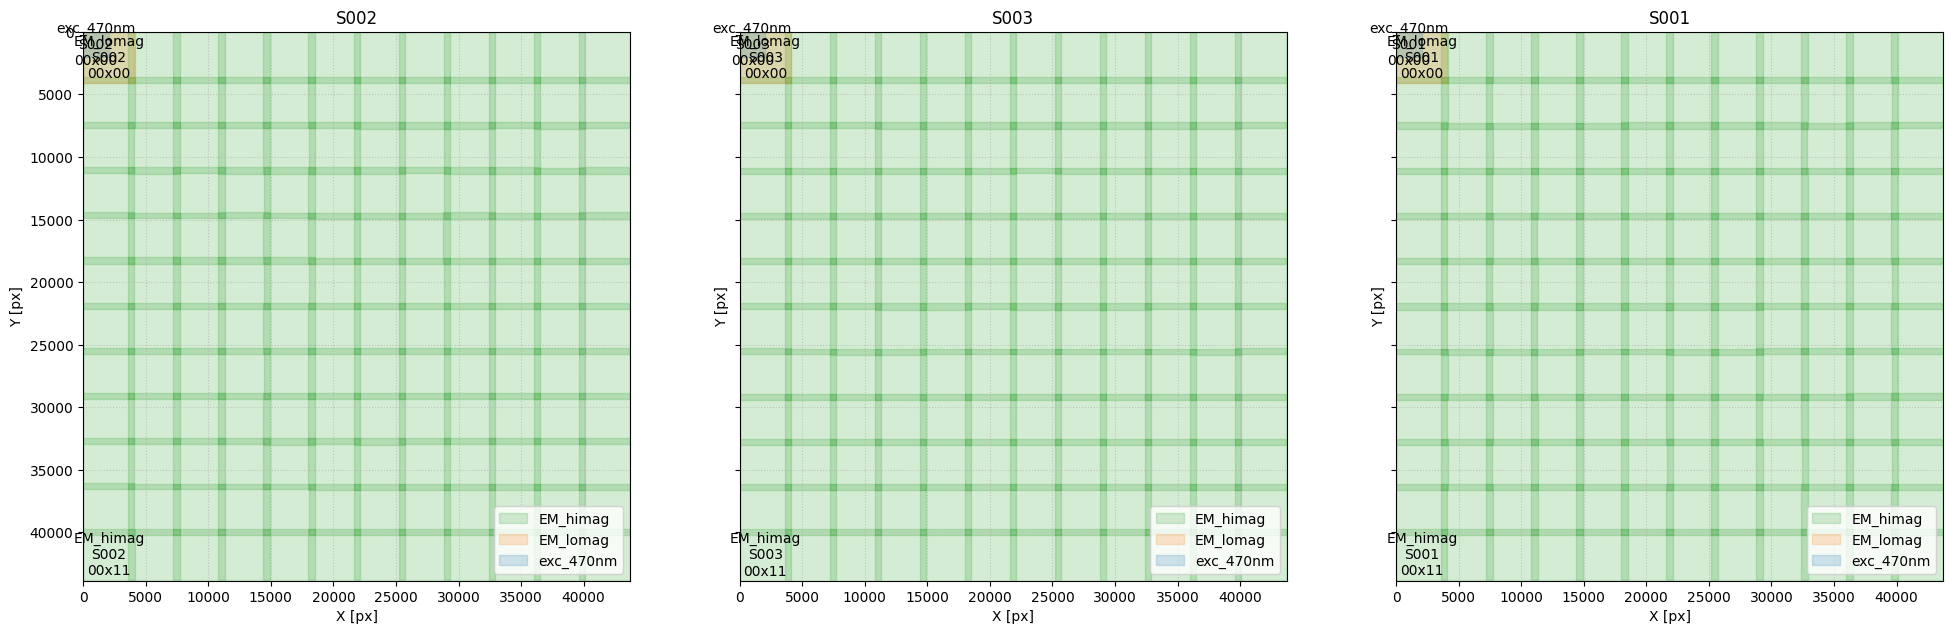

In [ ]:
# Get stacks
stacks = renderapi.render.get_stacks_by_owner_project(render=render)

# Plot tile map
stacks_2_plot = stacks
icatapi.plot_tile_map(stacks_2_plot,
                      render=render)

  0%|          | 0/9 [00:00<?, ?it/s]

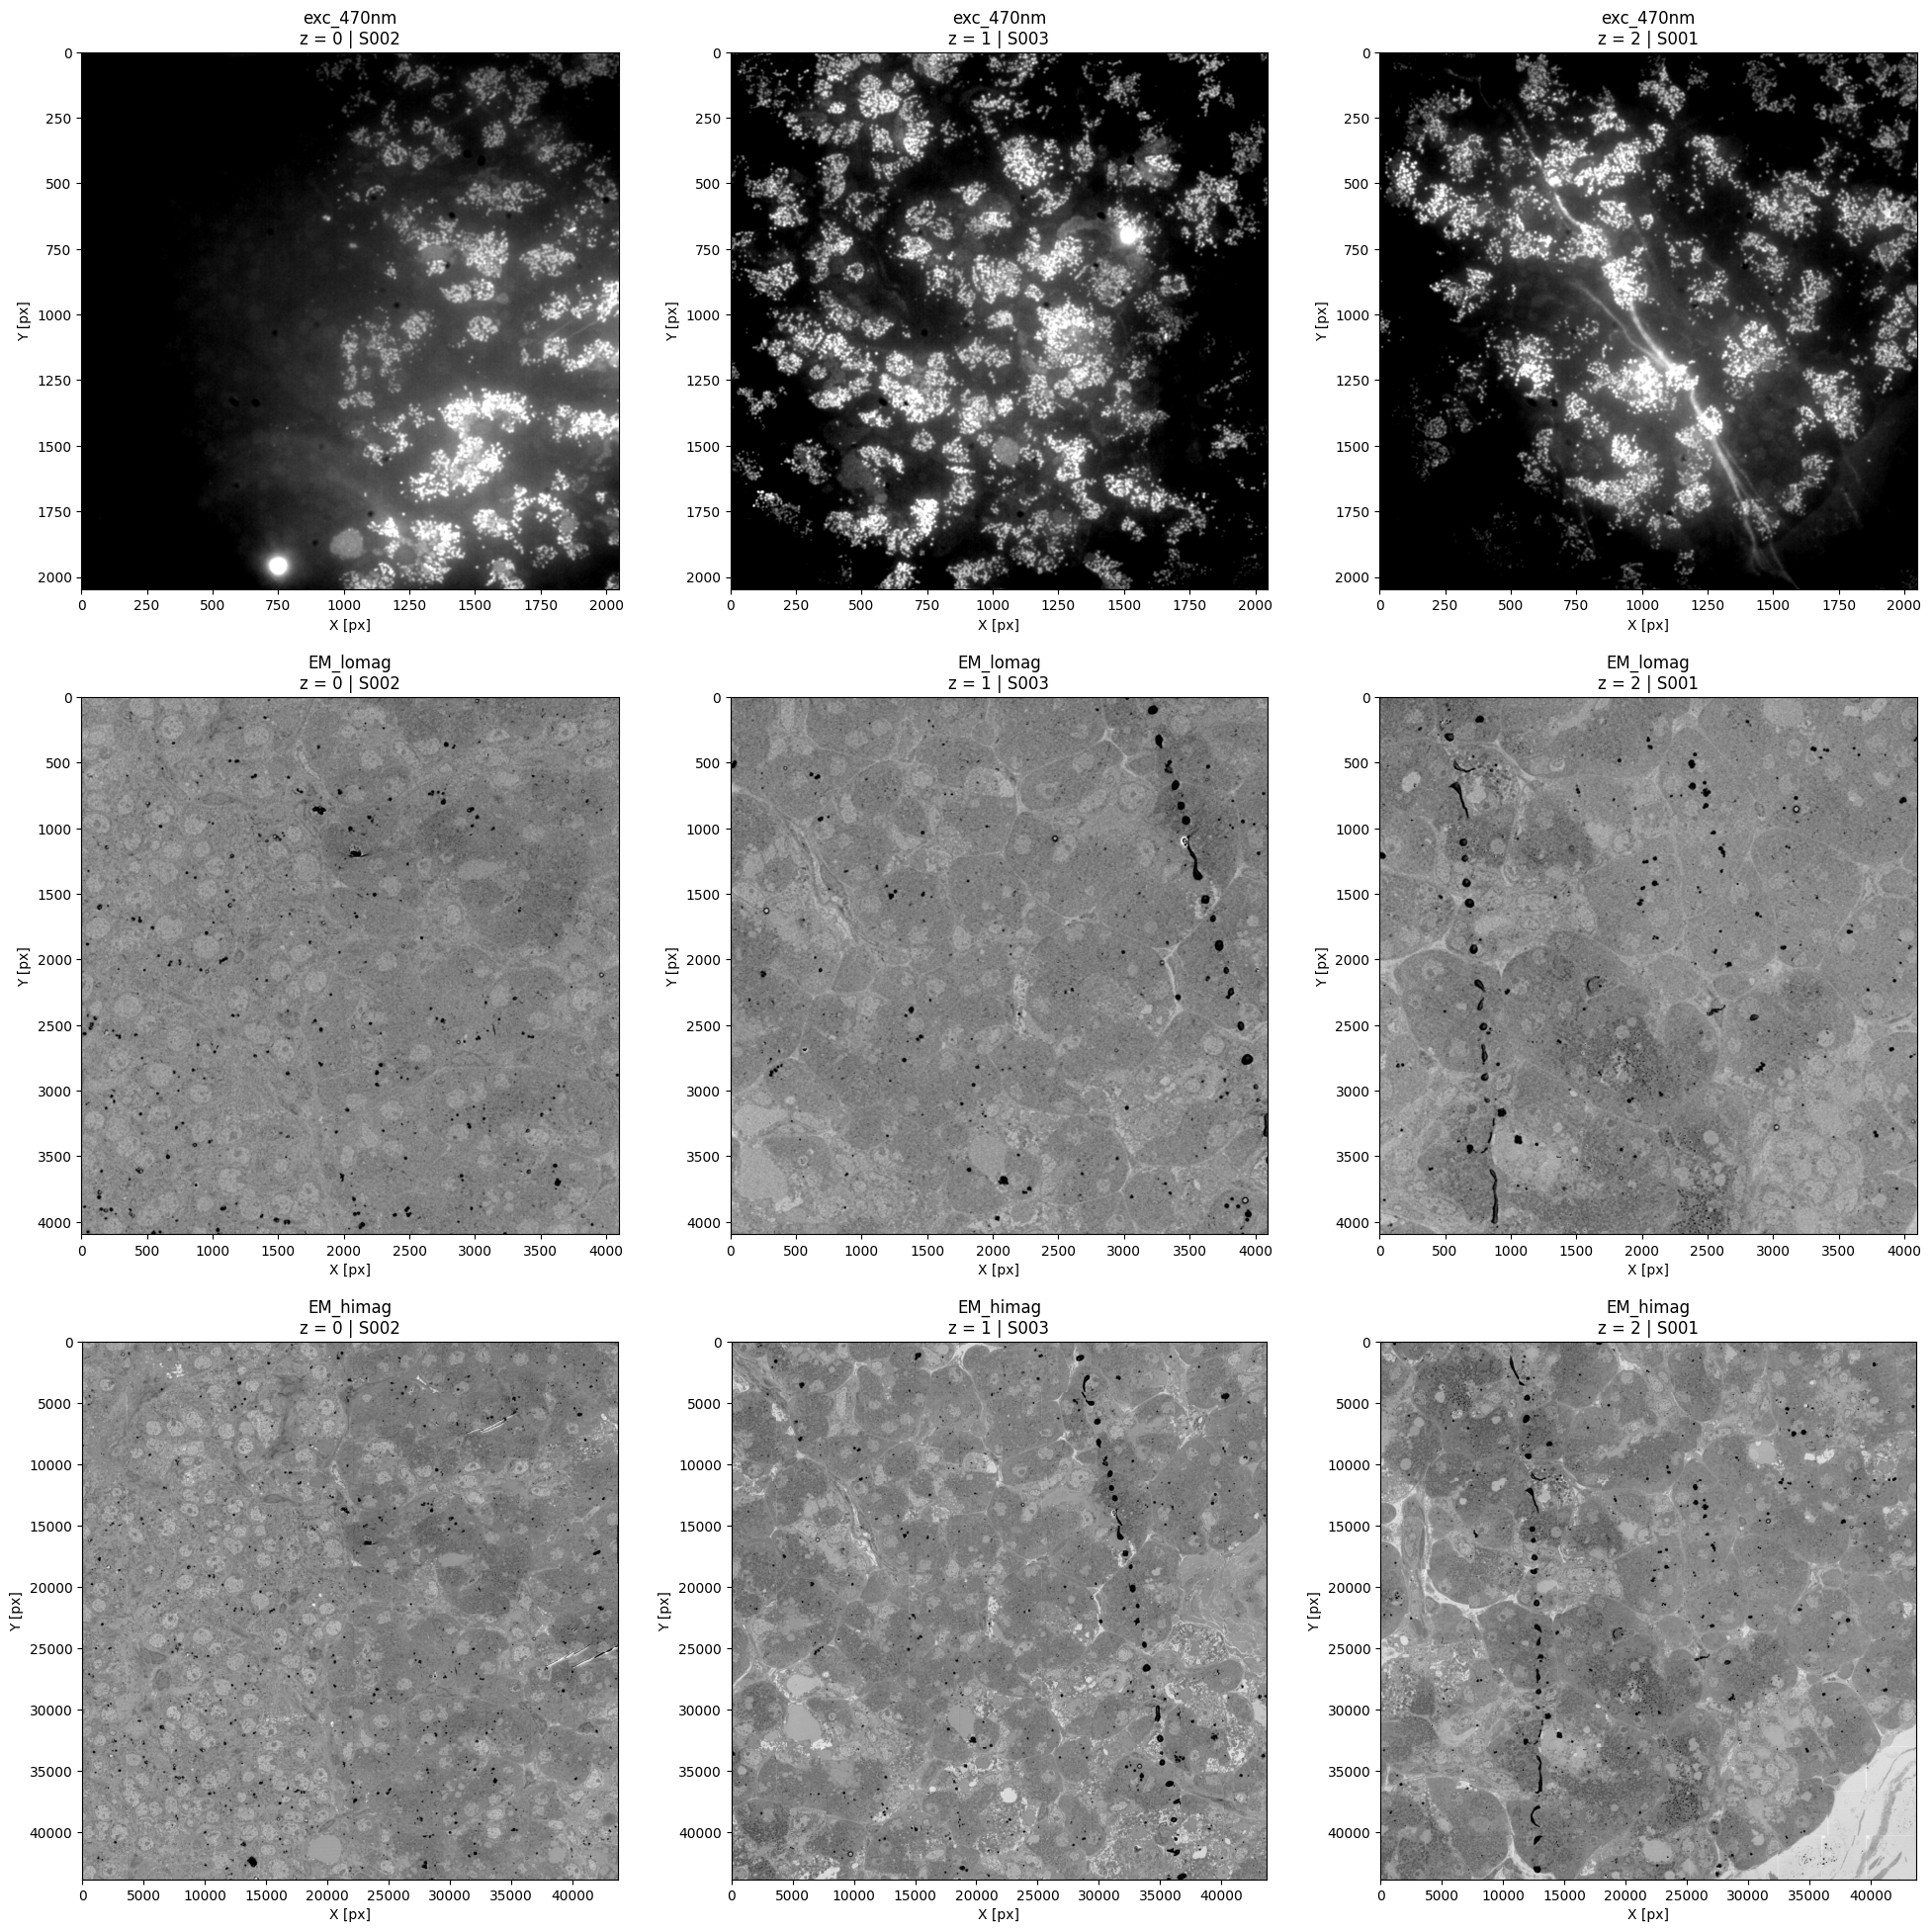

In [ ]:
# Plot stack images
icatapi.plot_stacks(stacks=stacks_2_plot,
                    maxTileSpecsToRender=500,
                    render=render)